In [1]:
from __future__ import division
from pyoperators import pcg
from pysimulators import profile

# QUBIC packages
import qubic
from qubicpack.utilities import Qubic_DataDir
from qubic.data import PATH
from qubic.io import read_map
from qubic import QubicSkySim as qss
import sys
sys.path.append('/Users/mregnier/Desktop/PhD Regnier/mypackages')


import Acquisition as Acq

# Display packages
import healpy as hp
import matplotlib.pyplot as plt

# FG-Buster packages
import component_model as c
import mixing_matrix as mm

# General packages
import numpy as np
import pysm3
import warnings
from qubic import QubicSkySim as qss
import pysm3.units as u
from importlib import reload
from pysm3 import utils
import myPCG as mypcg

from qubic import SpectroImLib as sp
from importlib import reload
import gc
import copy
from pyoperators import *


# PyOperators packages
from pyoperators import (
    BlockColumnOperator, BlockDiagonalOperator, BlockRowOperator,
    CompositionOperator, DiagonalOperator, I, IdentityOperator,
    MPIDistributionIdentityOperator, MPI, proxy_group, ReshapeOperator,
    rule_manager, pcg, Operator)

from pysimulators.interfaces.healpy import HealpixConvolutionGaussianOperator
warnings.filterwarnings("ignore")
# %matplotlib inline

## Now QUBIC and Planck acquisitions used for reconstruction

def integration(nu_min, nu_max, Nintegr, sky_config, d, fwhm_subbands = None):
    print(f'Integration from {nu_min:.2f} to {nu_max:.2f} GHz with {Nintegr} steps')
    obj = Acq.QubicIntegrated(d, Nsub=Nintegr, Nrec=Nintegr)
    if Nintegr == 1:
        allnus = np.array([np.mean([nu_min, nu_max])])
    else:
        allnus = np.linspace(nu_min, nu_max, Nintegr)
    m = obj.get_PySM_maps(sky_config, nus=allnus)
    
    if fwhm_subbands is not None:
        for i in range(Nintegr):
            C = HealpixConvolutionGaussianOperator(fwhm=fwhm_subbands[i])
            m[i] = C(m[i])
    
    return np.array([np.mean(m, axis=0)])


# # %config InlineBackend.figure_format='retina'
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

/Users/hamilton/Python/GitQubic/qubic/qubic/scripts/Tutorials-MapMaking/


In [2]:
reload(Acq)
nside = 256
relative_bandwidth = 0.25
band = 220
band_planck = 217
seed = 42
noiseless = False
effective_duration = 3e0
rwplanck = 1.
tol = 1e-40
noise_planck_level = 0
noise_qubic_level = 0


npointings = 3000
Nf_TOD = 4
Nf_recon = 1
fact_sub = 4

reload(Acq)

# Repository for dictionary
global_dir = Qubic_DataDir()
print(global_dir)
dictfilename = global_dir + 'dicts/pipeline_demo.dict'

# Read dictionary chosen
d_TOD = qubic.qubicdict.qubicDict()
d_TOD.read_from_file(dictfilename)

d_TOD['nf_recon'] = Nf_TOD
d_TOD['nf_sub'] = Nf_TOD
d_TOD['nside'] = nside
npix=12*d_TOD['nside']**2
d_TOD['RA_center'] = 0
d_TOD['DEC_center'] = -57
center = qubic.equ2gal(d_TOD['RA_center'], d_TOD['DEC_center'])
d_TOD['effective_duration'] = effective_duration
d_TOD['npointings'] = npointings
d_TOD['tol'] = 5e-4
d_TOD['filter_nu'] = band * 1e9
d_TOD['photon_noise'] = False#not noiseless
d_TOD['noiseless'] = noiseless
d_TOD['config'] = 'FI'
d_TOD['MultiBand'] = True
d_TOD['planck'] = True
d_TOD['dtheta'] = 15
#d_TOD['synthbeam_dtype'] = float

print('*************** Noise **************')
print('Noisless:      {}'.format(d_TOD['noiseless']))
print('Photon Noise:  {}'.format(d_TOD['photon_noise']))
print('************************************')

sky_config = {'cmb':42}
#sky_config = {'dust':'d0'}
#sky_config = {'cmb':3, 'dust':'d0'}

reload(Acq)
qubic_acquisition = Acq.QubicIntegrated(d_TOD, Nsub=Nf_TOD, Nrec=Nf_TOD)
cov = qubic_acquisition.get_coverage()
covnorm = cov/cov.max()
threshold = 0
#seenpix = generate_circular_mask(256, 10, center[0], center[1])
seenpix = covnorm > threshold
notseenpix = covnorm < threshold

m_sub = qubic_acquisition.get_PySM_maps(sky_config, qubic_acquisition.allnus)
print(m_sub.shape)

/Users/hamilton/Python/GitQubic/qubic/qubic/scripts/Tutorials-MapMaking/
/Users/hamilton/Python/GitQubic/qubic/qubic/scripts/Tutorials-MapMaking/
/Users/hamilton/Python/GitQubic/qubic/qubic/
*************** Noise **************
Noisless:      False
Photon Noise:  False
************************************
/Users/hamilton/Python/GitQubic/qubic/qubic/scripts/Tutorials-MapMaking/
You asked 3000 pointings with repeat strategy so I will provide 1000 pointings repeated 3 times.
Info MacJCH.local: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
(4, 786432, 3)


# QUBIC TOD

In [3]:
# Create Nsub maps
m_sub = qubic_acquisition.get_PySM_maps(sky_config, qubic_acquisition.allnus)
qubic_acquisition = Acq.QubicIntegrated(d_TOD, Nsub=Nf_TOD, Nrec=Nf_TOD)

# Create operator
H_TOD = qubic_acquisition.get_operator(convolution=True, myfwhm=None, fixed_data=None)
n_qubic = qubic_acquisition.get_noise()

# Create TOD
if Nf_recon == 1 and fact_sub == 1:
    TOD_QUBIC = H_TOD(m_sub[0]).ravel() + (n_qubic.ravel() * noise_qubic_level)
else:
    TOD_QUBIC = H_TOD(m_sub).ravel() + (n_qubic.ravel() * noise_qubic_level)

You asked 3000 pointings with repeat strategy so I will provide 1000 pointings repeated 3 times.
Info MacJCH.local: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info MacJCH.local: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info MacJCH.local: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info MacJCH.local: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Making sum from 192.50 to 204.98
Making sum from 204.98 to 218.27
Making sum from 218.27 to 232.43
Making sum from 232.43 to 247.50


# Planck TOD

Integration from 182.00 to 252.00 GHz with 4 steps
You asked 3000 pointings with repeat strategy so I will provide 1000 pointings repeated 3 times.
Planck maps for TOD
0 0.0042841330748209575
All Planck maps
0 0.0051727477991670824
1 0.004857750299778311
2 0.004561934757150926
3 0.0042841330748209575


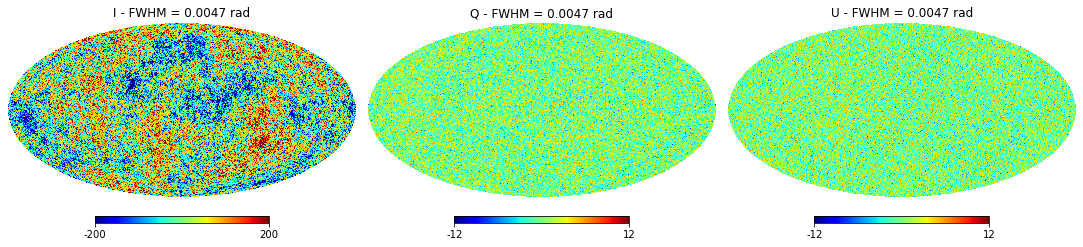

[-62.72118074   0.81356033  -1.20673017 ... -87.96955109  -1.5616772
   0.38035862]


In [18]:
planck_acquisition = Acq.PlanckAcquisition(band_planck, qubic_acquisition.scene)

d_formaps = copy.deepcopy(d_TOD)
d_formaps['nf_recon'] = Nf_recon
d_formaps['nf_sub'] = Nf_recon * fact_sub

planck_obs = integration(band_planck-35, band_planck+35, qubic_acquisition.Nsub, sky_config, d_formaps, fwhm_subbands=None) # Planck map
n_planck = planck_acquisition.get_noise()  # Planck noise

m_planck_for_tod = np.zeros((Nf_recon, 12*nside**2, 3))
m_planck_all = np.zeros((Nf_recon * fact_sub, 12*nside**2, 3))

# Convolving Planck map to QUBIC resolutions
print('Planck maps for TOD')
for i in range(Nf_recon):
    
    target = np.min(qubic_acquisition.allfwhm[i*fact_sub:(i+1)*fact_sub])                   # Target FWHM
    print(i,target)
    C = HealpixConvolutionGaussianOperator(fwhm=target)                                     # Operator
    m_planck_for_tod[i] = C(m_sub[i] + n_planck.copy() * noise_planck_level)                # Convolution

print('All Planck maps')
for i in range(Nf_recon*fact_sub):
    
    target = qubic_acquisition.allfwhm[i]                   # Target FWHM
    print(i,target)
    C = HealpixConvolutionGaussianOperator(fwhm=target)                                     # Operator
    m_planck_all[i] = C(m_sub[i] + n_planck.copy() * noise_planck_level)                    # Convolution
    
plt.figure(figsize=(15, 5))
stk = ['I', 'Q', 'U']
j=0
for i in range(Nf_recon):
    for k in range(3):
        if k == 0:
            r = 200
        else:
            r = 12
        hp.mollview(m_planck_for_tod[i, :, k], cmap='jet', sub=(Nf_recon, 3, j+1), min=-r, max=r, title=f'{stk[k]} - FWHM = {np.mean(qubic_acquisition.allfwhm[i*fact_sub:(i+1)*fact_sub]):.4f} rad')
        j+=1

plt.show()

R = ReshapeOperator(m_planck_for_tod.shape, (m_planck_for_tod.shape[0]*m_planck_for_tod.shape[1]*m_planck_for_tod.shape[2]))
TOD_PLANCK = R(m_planck_for_tod)

print(TOD_PLANCK)

# Final TOD

In [19]:
print(TOD_QUBIC)
print(TOD_PLANCK)

[ 4.18670490e-19 -1.84994939e-19  1.88734697e-18 ... -1.39471738e-18
 -6.80297522e-19  2.32731227e-19]
[-62.72118074   0.81356033  -1.20673017 ... -87.96955109  -1.5616772
   0.38035862]


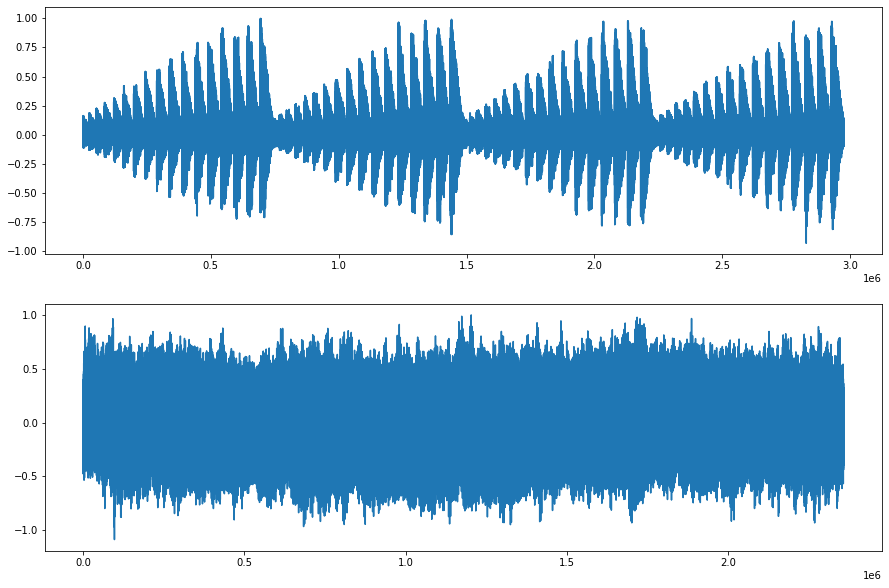

In [5]:
tod = np.r_[TOD_QUBIC, TOD_PLANCK]

plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(TOD_QUBIC/TOD_QUBIC.max())

plt.subplot(2, 1, 2)
plt.plot(TOD_PLANCK/TOD_PLANCK.max())

plt.show()

In [6]:
# QUBIC acqusition
qubic_acquisition = Acq.QubicIntegrated(d_formaps, Nsub=Nf_recon * fact_sub, Nrec=Nf_recon)
qubicplanck_acquisition = Acq.QubicPlanckMultiBandAcquisition(qubic_acquisition, planck_acquisition)

myfwhm = np.array([])

for i in range(Nf_recon):
    myfwhm = np.append(myfwhm, np.sqrt(qubic_acquisition.allfwhm[i*fact_sub:(i+1)*fact_sub]**2 - np.min(qubic_acquisition.allfwhm[i*fact_sub:(i+1)*fact_sub])**2))

print(f'Reconstruction using FWHM : {myfwhm} [rad]')

You asked 3000 pointings with repeat strategy so I will provide 1000 pointings repeated 3 times.
Reconstruction using FWHM : [0.00289888 0.00228997 0.00156763 0.        ] [rad]


In [7]:
d_formaps = copy.deepcopy(d_TOD)
d_formaps['nf_recon'] = Nf_recon
d_formaps['nf_sub'] = Nf_recon * fact_sub

# QUBIC acqusition
qubic_acquisition = Acq.QubicIntegrated(d_formaps, Nsub=Nf_recon * fact_sub, Nrec=Nf_recon)

# Joint acquisition
qubicplanck_acquisition = Acq.QubicPlanckMultiBandAcquisition(qubic_acquisition, planck_acquisition)
R = ReshapeOperator((1, 786432, 3), (786432, 3))

user = 'Pierre'
M = Acq.get_preconditioner(np.ones(12*nside**2))
if user == 'full':
    
    H = qubicplanck_acquisition.get_operator(convolution=True, myfwhm=myfwhm, fixed_data=None)
    invN = qubicplanck_acquisition.get_invntt_operator(beam_correction=None, seenpix=None, mask=None)

    with rule_manager(none=True):
        if Nf_recon == 1:
            A = R.T * (H.T * invN * H) * R
            b = R.T * (H.T * invN * tod)
        else:
            A = (H.T * invN * H)
            b = (H.T * invN * tod)
        
elif user == 'Pierre':
    H = qubicplanck_acquisition.get_operator(convolution=True, myfwhm=myfwhm, fixed_data=None)
    invN = qubicplanck_acquisition.get_invntt_operator(beam_correction=None, seenpix=None, mask=None)
    
    ### Solve PCG
    U = (
        ReshapeOperator((Nf_recon * sum(seenpix) * 3), (Nf_recon, sum(seenpix), 3)) *
        PackOperator(np.broadcast_to(seenpix[None, :, None], (Nf_recon, seenpix.size, 3)).copy())
    ).T

    with rule_manager(none=True):
        if Nf_recon == 1:
            A = U.T * R.T * H.T * invN * H * R * U
            x_planck = m_planck_for_tod * (1 - seenpix[None, :, None])
            b = U.T ( R.T * H.T * invN * (tod - H(R(x_planck))))
        else:
            A = U.T * H.T * invN * H * U
            x_planck = m_planck_for_tod * (1 - seenpix[None, :, None])
            b = U.T (  H.T * invN * (tod - H(x_planck)))
    
    
    
elif user == 'Mathias':
    fixed_data = m_planck_all.copy()
    fixed_data[:, seenpix, :] = 0
    H = qubicplanck_acquisition.get_operator(convolution=False, fixed_data=fixed_data)
    invN = qubicplanck_acquisition.get_invntt_operator(beam_correction=None, seenpix=None, mask=None)
    
    A = H.T * invN * H
    b = H.T * invN * tod
elif user == 'old':
    maskinit = np.array(seenpix, dtype=float)
    index_0 = maskinit == 0
    maskinit[index_0] += 1e10

    H = qubicplanck_acquisition.get_operator(convolution=False, fixed_data=None)
    invN = qubicplanck_acquisition.get_invntt_operator(beam_correction=None, seenpix=None, mask=None)
    
    A = H.T * invN * H
    b = H.T * invN * tod
    
    #for i in range(1, Nf_recon+1):
    #    invN.operands[i].operands[1] /= DiagonalOperator(np.array([maskinit, maskinit, maskinit]).T)
else:
    raise TypeError('We would like to have more people..')

You asked 3000 pointings with repeat strategy so I will provide 1000 pointings repeated 3 times.
Info MacJCH.local: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info MacJCH.local: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info MacJCH.local: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info MacJCH.local: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Making sum from 192.50 to 247.50


In [8]:
if user == 'Pierre' or user == 'Mathias':
    m_ini = m_planck_for_tod.copy()
    solution_qubic_planck = mypcg.pcg(A, b, x0=m_planck_for_tod[:, seenpix], M=M, tol=tol, disp=True, maxiter=30)
elif user == 'full':
    solution_qubic_planck = mypcg.pcg(A, b, x0=m_planck_for_tod, M=M, tol=tol, disp=True, maxiter=30)
elif user == 'old':
    solution_qubic_planck = mypcg.pcg(A, b, x0=m_planck_for_tod[0], M=M, tol=tol, disp=True, maxiter=30)
else:
    raise TypeError('We would like to have more people..')

   1: 0.00017710205482890444
   2: 0.0001776465871636683
   3: 0.00016737167581017972
   4: 0.00011480342932621429
   5: 8.0475857551115e-05
   6: 6.722461539003679e-05
   7: 7.130021336427399e-05
   8: 6.208394958329768e-05
   9: 7.085405397027414e-05
  10: 5.01823197920737e-05
  11: 3.744989716228002e-05
  12: 3.349871476959991e-05
  13: 3.302764240503357e-05
  14: 4.435943211435036e-05
  15: 3.083347444593761e-05
  16: 3.141450620319666e-05
  17: 2.2997667484179714e-05
  18: 1.9410576177751685e-05
  19: 1.6223841030666002e-05
  20: 2.602386405613211e-05
  21: 1.5087939557559892e-05
  22: 1.6805703628771665e-05
  23: 1.1324426263950282e-05
  24: 9.237404714013162e-06
  25: 8.550056866836475e-06
  26: 1.1513706328184178e-05
  27: 8.537601652886178e-06
  28: 7.68676405748776e-06
  29: 5.540084755912761e-06
  30: 4.7208983437194795e-06


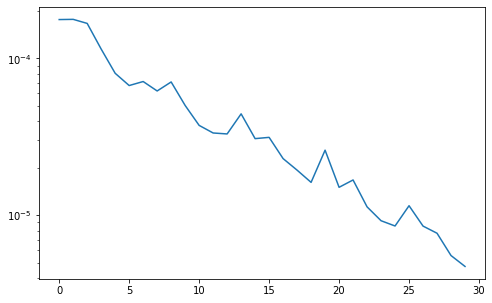

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(solution_qubic_planck['x']['convergence'])
plt.yscale('log')
plt.show()

In [20]:
print(solution_qubic_planck['x']['x'])

[[[-55.73221705   4.2118969   -0.43275735]
  [-19.03058008  -2.16697482  -1.30211832]
  [ 35.40907285   1.79421062  -1.0003886 ]
  ...
  [-38.86703539   1.53194372  -4.34138937]
  [-22.98288161   1.09065182   4.68865203]
  [-87.96966524  -1.56162957   0.38001553]]]


In [10]:
#### COmmented by JC as not used
# def get_inputs(m, fwhm):
    
#     mean_m = np.zeros((m.shape[1], m.shape[2]))
#     for i in range(m.shape[0]):
#         print(fwhm[i])
#         C = HealpixConvolutionGaussianOperator(fwhm=fwhm[i])
#         mean_m += m[i]/m.shape[0]
#     return mean_m

In [21]:
mysolution = m_planck_for_tod.copy()
if user == 'Pierre' or user == 'Mathias':
    mysolution[:, seenpix] = solution_qubic_planck['x']['x'].copy()
elif user == 'old' or user == 'full':
    mysolution = solution_qubic_planck['x']['x'].copy()
else:
    raise TypeError('We would like to have more people..')

In [22]:
mysolution

array([[[-6.27211807e+01,  8.13560329e-01, -1.20673017e+00],
        [ 7.55619231e+01, -5.54365136e-01,  2.56776785e+00],
        [ 8.67030087e+01,  3.40914884e-01, -4.72249731e-02],
        ...,
        [-3.88670354e+01,  1.53194372e+00, -4.34138937e+00],
        [-2.29828816e+01,  1.09065182e+00,  4.68865203e+00],
        [-8.79696652e+01, -1.56162957e+00,  3.80015526e-01]]])

In [12]:
###### Commented by JC as not used
# inputs0 = m_planck_for_tod[0].copy()

# if user == 'Pierre' or user == 'Mathias':
#     inputs0[seenpix] = get_inputs(m_sub[:fact_sub], qubic_acquisition.allfwhm[:fact_sub])[seenpix]
# elif user == 'old':
#     inputs0[seenpix] = get_inputs(m_sub[:fact_sub], qubic_acquisition.allfwhm[:fact_sub])[seenpix]
# elif user == 'full':
#     inputs0 = get_inputs(m_sub[:fact_sub], qubic_acquisition.allfwhm[:fact_sub])
# else:
#     raise TypeError('We would like to have more people..')
# inputs = np.array([inputs0])

In [13]:
C = HealpixConvolutionGaussianOperator(fwhm=np.min(qubic_acquisition.allfwhm[:fact_sub]), iter=3, pol=True)
myinputs = C(planck_obs[0]).copy()

In [24]:
np.mean(myinputs)

0.007079034900814387

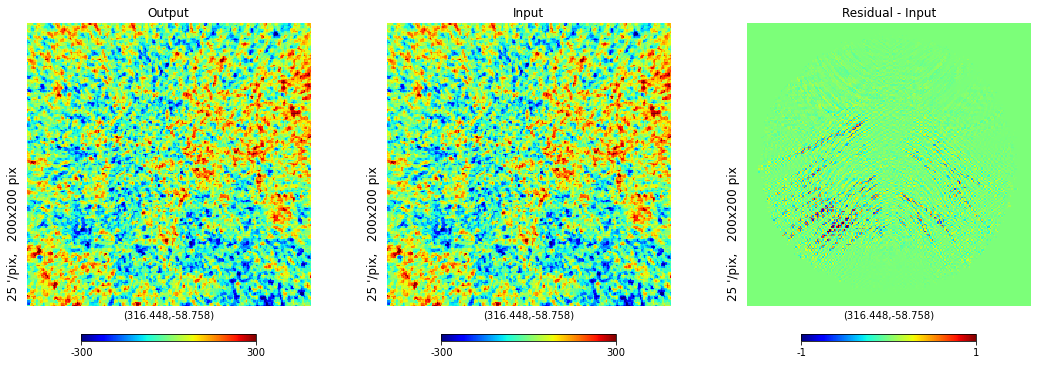

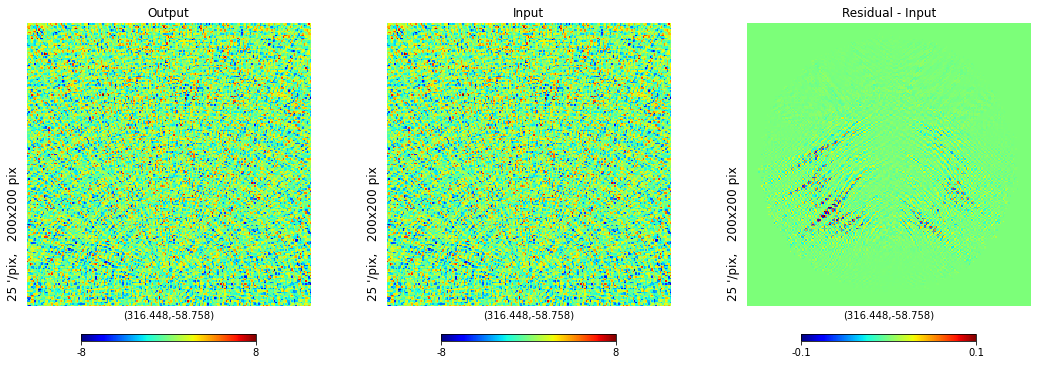

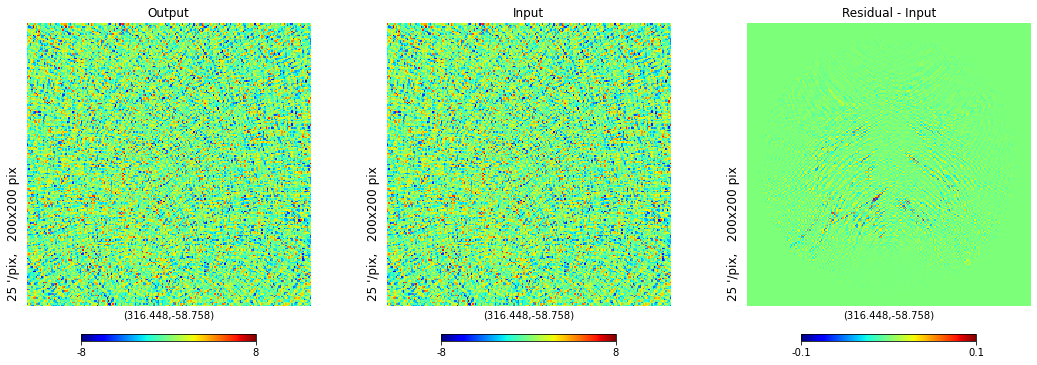

In [25]:
res=25
istk=0
minr=10


for i in range(3):
    if i == 0:
        r = 1
        v = 300
    else:
        r = 0.1
        v = 8
    plt.figure(figsize=(15, 10))
    hp.gnomview(mysolution[0, :, i], cmap='jet', rot=center, reso=res, min=-v, max=v, sub=(2, 3, 1), title='Output')
    hp.gnomview(myinputs[:, i], cmap='jet', rot=center, reso=res, min=-v, max=v, sub=(2, 3, 2), title='Input')

    hp.gnomview(mysolution[0, :, i]-myinputs[:, i], cmap='jet', rot=center, reso=res, title='Residual - Input',
                            min=-r, max=r, sub=(2, 3, 3))
    
    plt.show()

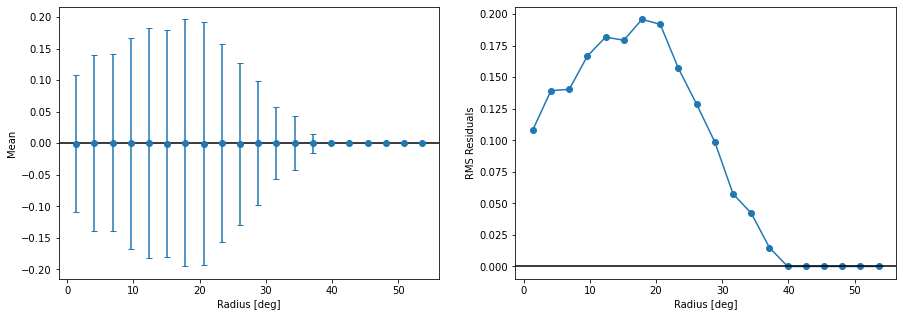

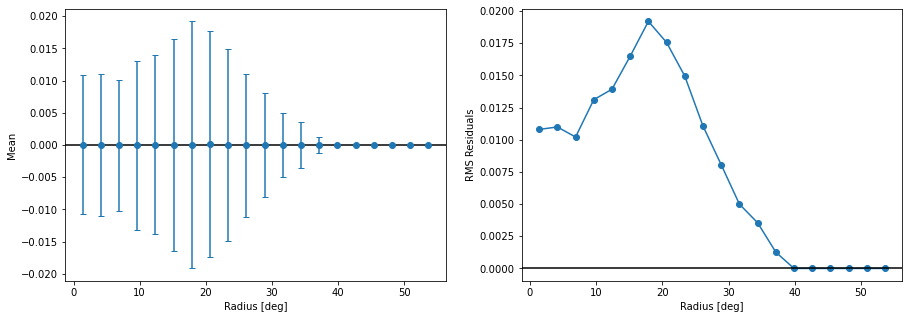

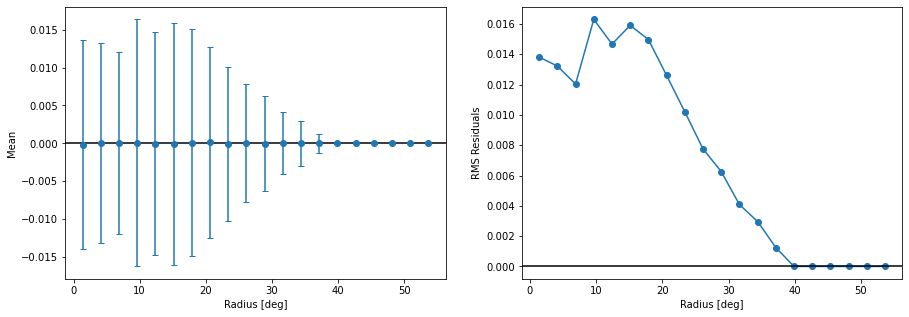

In [15]:
import qubic.fibtools as ft
covnorm = cov/np.max(cov)
uvpix = np.array(hp.pix2vec(hp.npix2nside(len(cov)), np.arange(len(cov))))
uvcenter = np.array(hp.pix2vec(hp.npix2nside(len(cov)), np.argmax(cov)))
dcenter = np.degrees(np.arccos(np.dot(uvpix.T, uvcenter)))

for i in range(3):
    new_res0 = mysolution[0, :, i]-myinputs[:, i]
    #new_res1 = mysolution[0,:, i]-m_dust[:, i]#inputs[0, :, i]
    x0,y0,sx0,sy0,_ = ft.profile(dcenter, new_res0, nbins=20, rng=[0,55], plot=False)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.errorbar(x0, y0, yerr=sy0, fmt='o', capsize=3)
    plt.axhline(0, color='black')
    plt.xlabel('Radius [deg]')
    plt.ylabel('Mean')
    plt.subplot(1, 2, 2)
    plt.plot(x0, sy0,'o-')
    plt.xlabel('Radius [deg]')
    plt.ylabel('RMS Residuals')
    plt.axhline(0, color='black')
    plt.show()